**Бизнес-постановка задачи:**  
Разработать рекомендательную систему, с целью повысить прибыль от допродаж в интернет-магазине, на 20 %

**Техническая задача:**  
Разместить на главное странице сайта рекомендации товаров по идентификатору пользователя в трех местах.

* Создать сервис, выдающий рекомендации по идентификатору пользователя.
* Обёрнуть сервис в Docker.
* Написать документацию, описание функциональности.
* Сделать презентацию для менеджера с описанием принципов работы..

**Техническая метрика оценки качества:**  
Precision@3

# Первоначальный анализ данных

In [1]:
!pip install   holidays

In [2]:
import pandas as pd
import numpy as np

import datetime 
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from   xgboost  import XGBClassifier
from sklearn import metrics

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from sklearn import preprocessing

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

In [3]:
events            = pd.read_csv( 'events.csv')
category_tree     = pd.read_csv( 'category_tree.csv')
item_properties_1 = pd.read_csv( 'item_properties_part1.csv')
item_properties_2 = pd.read_csv( 'item_properties_part2.csv')

# Объеденим свойства товара в один датасет
item_properties = pd.concat([item_properties_1, item_properties_2], ignore_index=True)

**events** — датасет с событиями. Колонки:
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

**category_tree** — файл с деревом категорий (можно восстановить дерево).
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства.

# Исследование данных

In [4]:
num_records = events.shape[0]
print("Количество записей событий в датасете:", num_records)

Количество записей событий в датасете: 2756101


In [5]:
event_types = events['event'].unique()
print("Типы событий в датасете:", event_types)

Типы событий в датасете: ['view' 'addtocart' 'transaction']


In [6]:
display(events.head(3))
display(category_tree.head(3))
display(item_properties.head(3))

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


In [7]:
print(f'events: {events.shape}')
print(f'category_tree: {category_tree.shape}')
print(f'item_properties: {item_properties.shape}')

events: (2756101, 5)
category_tree: (1669, 2)
item_properties: (20275902, 4)


In [8]:
print(f'Типы событий: {events["event"].unique()}')
print(f'Количество уникальных признаков товара: {item_properties["property"].nunique()}')

Типы событий: ['view' 'addtocart' 'transaction']
Количество уникальных признаков товара: 1104


In [9]:
events ["data"] = pd.to_datetime(events ["timestamp"], unit='ms', origin='unix')

In [10]:
events

,timestamp,visitorid,event,itemid,transactionid,data
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106
...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703


In [11]:
print(f'Начальная дата: {events["data"].min()}')

print(f'Конечная дата: {events["data"].max()}')

Начальная дата: 2015-05-03 03:00:04.384000
Конечная дата: 2015-09-18 02:59:47.788000


## Задание 4.1
## Какой процент продаж обеспечивают топовые товары (точка отсечения — 1 июля)? Для топ-3 товаров по числу транзакций.

In [12]:
before_july = events[(events['data'] <= '2015-07-02') & (events['event'] == 'transaction')]
after_july  = events[(events['data'] > '2015-07-02')  & (events['event'] == 'transaction')]

# Найдем топ-3 товара до 1 июля по числу транзакций
top_items_before_july = before_july['itemid'].value_counts().head(3)

# Выделим транзакции с товарами из топ-3 после 1 июля
transactions_after_july = after_july[after_july['itemid'].isin(top_items_before_july.index)]

# Посчитаем процент продаж, которые обеспечивают эти топ-3 товара после 1 июля
percentage_sales_covered = transactions_after_july.shape[0] / after_july.shape[0] * 100

print(f"Процент продаж, обеспечиваемых топ-3 товарами после 1 июля: {percentage_sales_covered:.2f}%")

Процент продаж, обеспечиваемых топ-3 товарами после 1 июля: 0.61%


### Посмотрим на процент пропусков

In [13]:
round((events.isna().sum() / events.shape[0]) * 100, 2)

timestamp         0.00
visitorid         0.00
event             0.00
itemid            0.00
transactionid    99.19
data              0.00
dtype: float64

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1271: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data


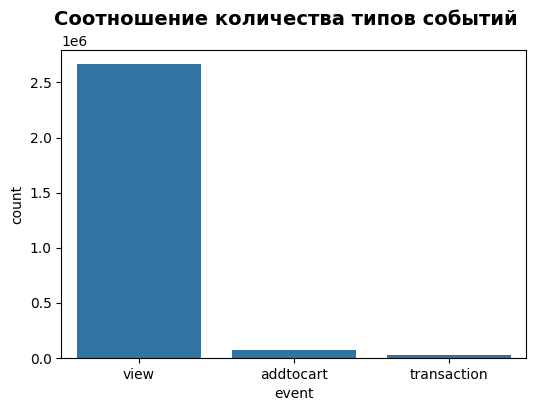

In [14]:
plt.figure(figsize=(6, 4))
event_countplot = sns.countplot(
    data=events,
    x='event')
plt.suptitle(
    'Соотношение количества типов событий',
    fontweight='bold',
    fontsize=14);

### Поиск дубликатов

In [15]:
dupl_columns = list(events.columns)

mask = events.duplicated(subset=dupl_columns)
print(f'Число найденных дубликатов в events: {events[mask].shape[0]}')

# удалим дубликаты
events = events.drop_duplicates(keep='first')

Число найденных дубликатов в events: 460


In [16]:
dupl_columns = list(item_properties.columns)

mask = item_properties.duplicated(subset=dupl_columns)
item_properties_duplicates = item_properties[mask]
print(f'Число найденных дубликатов в item_properties: {item_properties_duplicates.shape[0]}')

Число найденных дубликатов в item_properties: 0


## Колличество уникальных транзакций

In [17]:
events[~events['transactionid'].isna()]['transactionid'].nunique()

17672

In [18]:
# Разделим датасет по типу событий
events_view         = events[events['event'] == 'view']
events_addtocart    = events[events['event'] == 'addtocart']
events_transaction  = events[events['event'] == 'transaction']

In [19]:
# Рассчитаем количество событий для каждого айтема
item_popularity_view        = events_view.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_view'})
item_popularity_addtocart   = events_addtocart.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_addtocart'})
item_popularity_transaction = events_transaction.groupby('itemid')['event'].count().reset_index().rename(columns={'event': 'popularity_transaction'})

In [20]:
# Возьмем топ 50 популярных транзакций
df_view         = item_popularity_view.sort_values(by='popularity_view', ascending=False).head(50)
df_addtocart    = item_popularity_addtocart.sort_values(by='popularity_addtocart', ascending=False).head(50)
df_transaction  = item_popularity_transaction.sort_values(by='popularity_transaction', ascending=False).head(50)

In [21]:
# Объединеним данных по столбцу itemid, оставив только те события, который имеют все три события
merged_df = pd.merge(df_view, df_addtocart, on='itemid')
# Добавим процент добавленных в корзину, по отношению к просмотрам
merged_df['popularity_addtocart_%'] = round((merged_df['popularity_addtocart'] / merged_df['popularity_view']) * 100, 2)

merged_df = pd.merge(merged_df, df_transaction, on='itemid')
# Добавим процент выполненных транзакций, по отношению к добавленным в корзину
merged_df['popularity_transaction_%'] = round((merged_df['popularity_transaction'] / merged_df['popularity_addtocart']) * 100, 2)

merged_df

,itemid,popularity_view,popularity_addtocart,popularity_addtocart_%,popularity_transaction,popularity_transaction_%
0,461686,2538,304,11.98,133,43.75
1,309778,1565,48,3.07,15,31.25
2,257040,1531,89,5.81,27,30.34
3,384302,1528,65,4.25,15,23.08
4,7943,1346,97,7.21,46,47.42
5,320130,1333,141,10.58,33,23.40
6,234255,1214,77,6.34,16,20.78
7,190000,1164,47,4.04,20,42.55
8,37029,1131,71,6.28,25,35.21
9,369447,1103,80,7.25,31,38.75


###  с вывод, что товар с id 461686 является  популярным, его больше всего просматривают, с 12% верятностью добавляют в корзину 

###  популарны  и товары с id 312728 и 445351

##  

# Создание факторов для модели
###  факторов, связанных с датой

In [22]:
import holidays

In [23]:
# Извлеким признаки
events['hour']          = events['data'].dt.hour
events['month']         = events['data'].dt.month
events['day_of_week']   = events['data'].dt.dayofweek
events['is_weekend']    = events['data'].dt.weekday // 5  # 1 - выходной, 0 - будний день
events['minute'] = events['data'].dt.minute
events['year'] = events['data'].dt.year
# Определим праздничные дни
us_holidays = holidays.US(years=events['data'].dt.year.unique())
events['is_holiday'] = events['data'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

# Определим временной признак
events['time_of_day'] = pd.cut(events['data'].dt.hour,
                           bins=[0, 6, 12, 18, 24],
                           labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                           include_lowest=True)

# Выведим результат
events.head()

,timestamp,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,12,2015,0,Night
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,2,2015,0,Night


In [24]:
#Удалим столбец timestamp

events.drop('timestamp', axis=1, inplace=True)

In [25]:
events.head()

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,12,2015,0,Night
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,2,2015,0,Night


In [26]:
item_properties ["data"] = pd.to_datetime( item_properties["timestamp"], unit='ms', origin='unix')

In [27]:
item_properties

,timestamp,itemid,property,value,data
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...,...
20275897,1433646000000,236931,929,n12.000,2015-06-07 03:00:00
20275898,1440903600000,455746,6,150169 639134,2015-08-30 03:00:00
20275899,1439694000000,347565,686,610834,2015-08-16 03:00:00
20275900,1433646000000,287231,867,769062,2015-06-07 03:00:00


In [28]:
#Удалим столбец timestamp
item_properties.drop('timestamp', axis=1, inplace=True)

In [29]:
item_properties

,itemid,property,value,data
0,460429,categoryid,1338,2015-06-28 03:00:00
1,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,59481,790,n15360.000,2015-05-10 03:00:00
4,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...
20275897,236931,929,n12.000,2015-06-07 03:00:00
20275898,455746,6,150169 639134,2015-08-30 03:00:00
20275899,347565,686,610834,2015-08-16 03:00:00
20275900,287231,867,769062,2015-06-07 03:00:00


### ТОП товаров и посетителей

In [30]:
user_interaction_counts = events.groupby(
    'visitorid')['event'].count().reset_index()
user_interaction_counts.rename(columns={'event': 'total_events_user'},
                               inplace=True)

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1271: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1271: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.

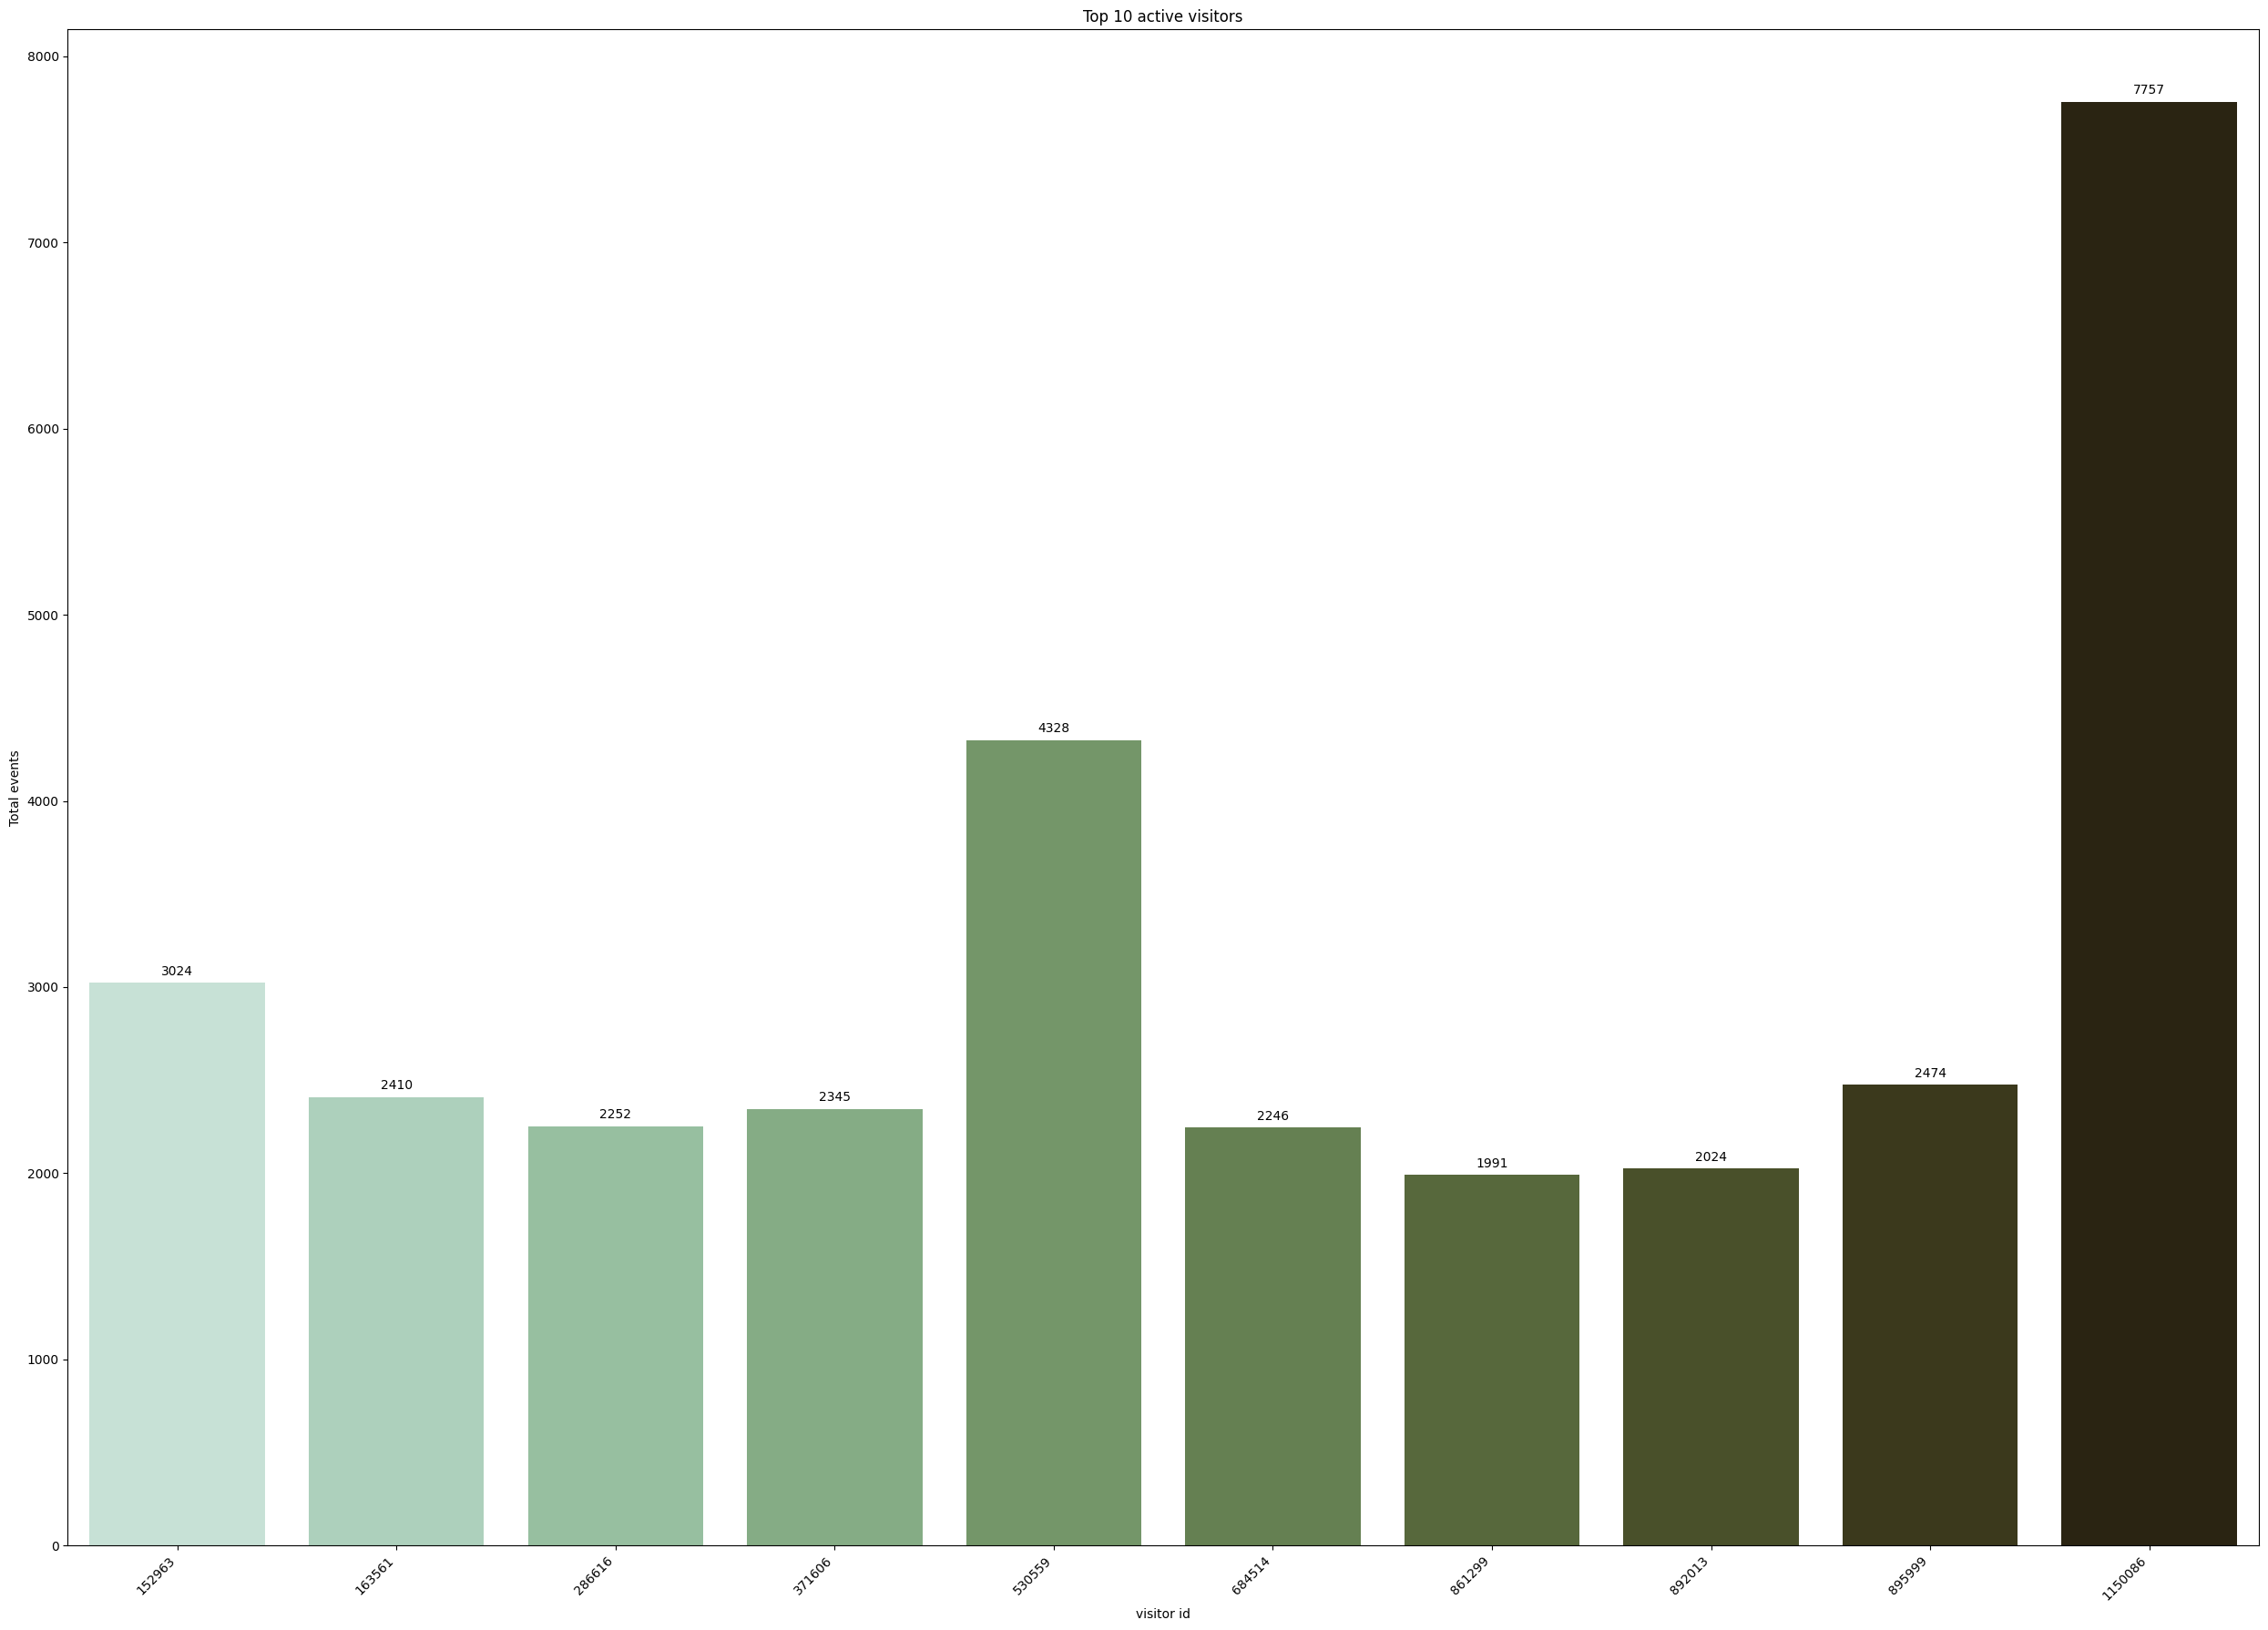

In [31]:
top_users = user_interaction_counts.sort_values(by='total_events_user', ascending=False).head(10)

plt.figure(figsize=(25,18))
ax = sns.barplot(data=top_users, x='visitorid', y='total_events_user', palette='ch:1.18')
plt.title('Top 10 active visitors')
plt.xlabel('visitor id')
plt.ylabel('Total events')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

#### ТОП 10 товаров

In [32]:
item_interaction_counts = events.groupby(
    'itemid')['event'].count().reset_index()
item_interaction_counts.rename(columns={'event': 'total_events_item'},
                               inplace=True)

c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1271: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1271: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data
c:\Users\Дмитрий\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.

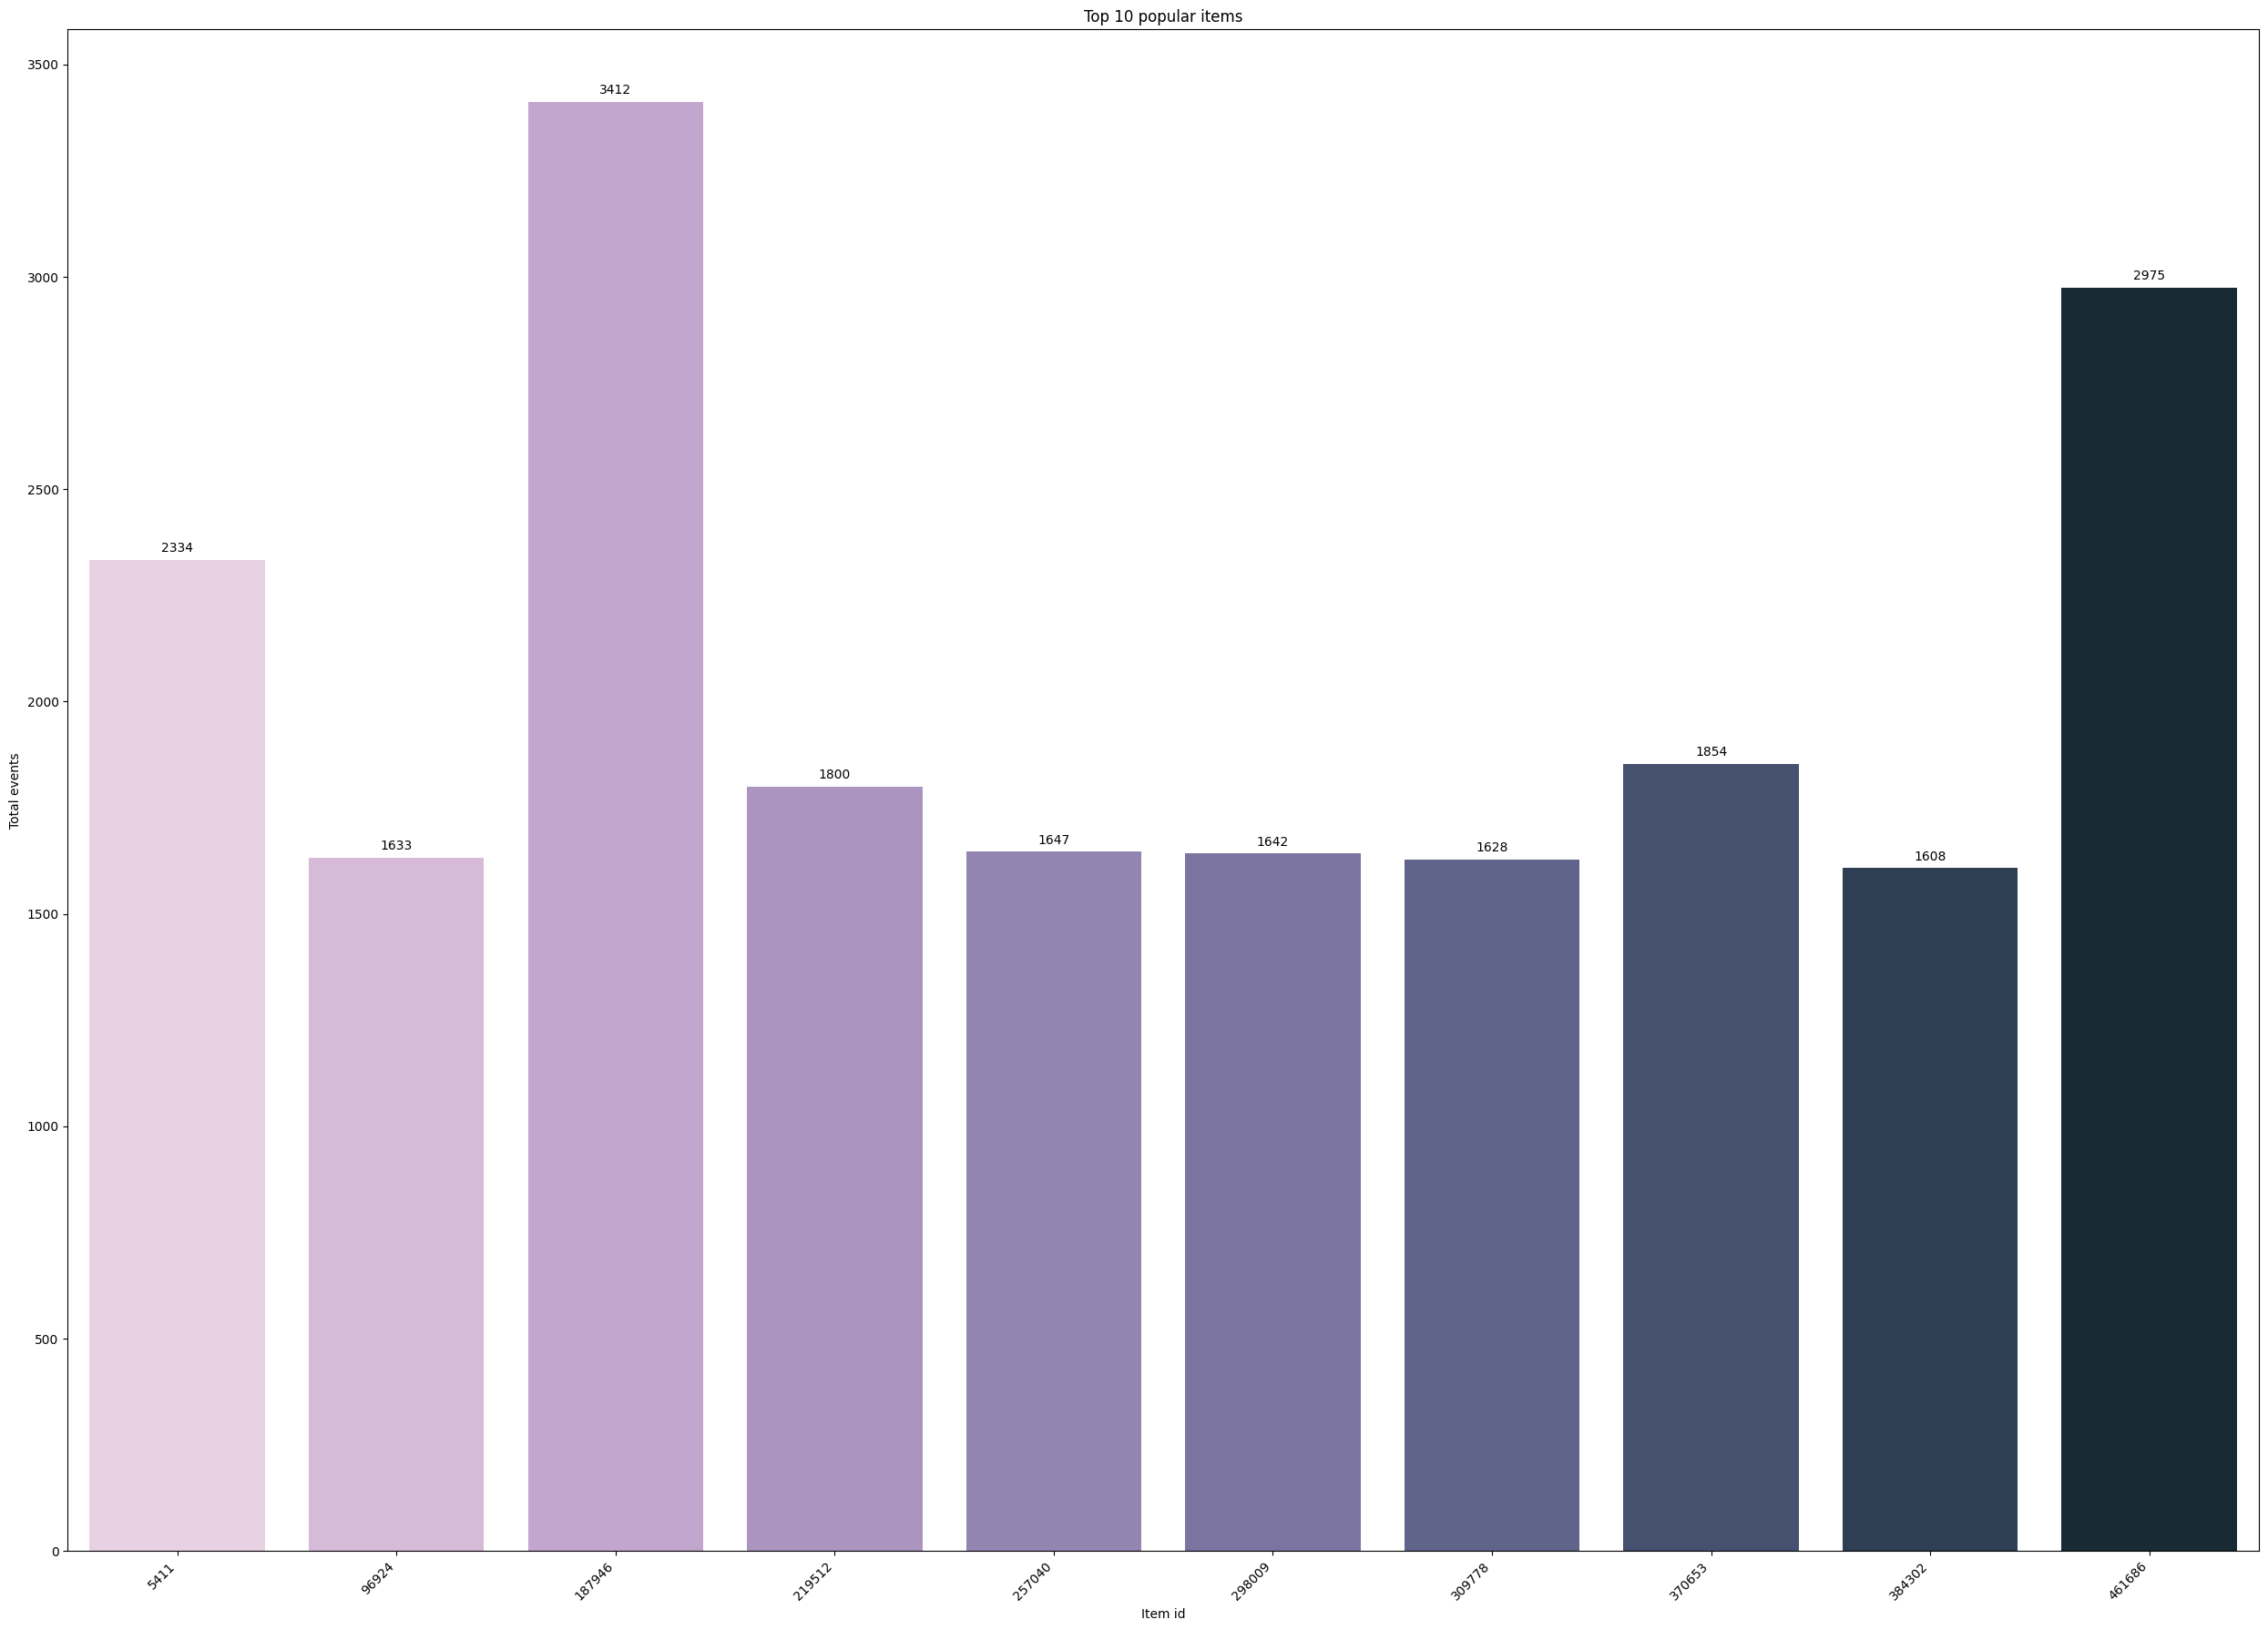

In [33]:
top_items = item_interaction_counts.sort_values(by='total_events_item',
                                                ascending=False).head(10)
plt.figure(figsize=(25, 18))
ax = sns.barplot(data=top_items,
                 x='itemid',
                 y='total_events_item',
                 palette='ch:5.48')
plt.title('Top 10 popular items')
plt.xlabel('Item id')
plt.ylabel('Total events')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [34]:
item_properties

,itemid,property,value,data
0,460429,categoryid,1338,2015-06-28 03:00:00
1,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,59481,790,n15360.000,2015-05-10 03:00:00
4,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...
20275897,236931,929,n12.000,2015-06-07 03:00:00
20275898,455746,6,150169 639134,2015-08-30 03:00:00
20275899,347565,686,610834,2015-08-16 03:00:00
20275900,287231,867,769062,2015-06-07 03:00:00


# Валидационный датасет

### Создадием валидационный датасет, разбив данные по времени. последние семь дней данных в качестве валидационного периода.

In [35]:
validation_period = events['data'].max() - pd.DateOffset(days=7)

# Разделим данные на тренировочный и валидационный датасеты
train_data      = events[events['data'] < validation_period]
validation_data = events[events['data'] >= validation_period]

print(f'Train data: {train_data.shape}')
print(f'Validation data: {validation_data.shape}')

Train data: (2640903, 13)
Validation data: (114738, 13)


In [36]:
validation_data

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day
1329693,453211,view,402448,NaN,2015-09-11 05:06:13.090,5,9,4,0,6,2015,0,Night
1329694,206733,view,273118,NaN,2015-09-11 05:00:40.292,5,9,4,0,0,2015,0,Night
1329695,15646,view,118789,NaN,2015-09-11 05:32:51.526,5,9,4,0,32,2015,0,Night
1329696,38429,view,80622,NaN,2015-09-11 04:56:59.917,4,9,4,0,56,2015,0,Night
1329697,35148,view,443139,NaN,2015-09-11 05:45:33.677,5,9,4,0,45,2015,0,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462514,1088606,view,82126,NaN,2015-09-18 01:58:01.522,1,9,4,0,58,2015,0,Night
1462515,444612,view,256931,NaN,2015-09-18 02:06:02.785,2,9,4,0,6,2015,0,Night
1462516,1128231,view,202067,NaN,2015-09-18 02:06:59.902,2,9,4,0,6,2015,0,Night
1462517,157029,view,454888,NaN,2015-09-18 01:47:48.781,1,9,4,0,47,2015,0,Night


## Объединие датасетов

In [37]:
data = events.merge(item_properties, on=['itemid', 'data'], how='left')

data= data.merge(category_tree, left_on='property', right_on='categoryid', how='left')

data.head()

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night,NaN,NaN,NaN,NaN
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night,NaN,NaN,NaN,NaN
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,12,2015,0,Night,NaN,NaN,NaN,NaN
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN


In [38]:
import pickle

In [39]:
# Сохраненим объединенный датасет
with open('E:\\DIPLOMA\\data.pickle', 'wb') as file:
    pickle.dump(data, file)

# просмотр

In [40]:
with open('data.pickle', 'rb') as f:
    loaded_model1 = pickle.load(f)
loaded_model1    

,visitorid,event,itemid,transactionid,data,hour,month,day_of_week,is_weekend,minute,year,is_holiday,time_of_day,property,value,categoryid,parentid
0,257597,view,355908,NaN,2015-06-02 05:02:12.117,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
1,992329,view,248676,NaN,2015-06-02 05:50:14.164,5,6,1,0,50,2015,0,Night,NaN,NaN,NaN,NaN
2,111016,view,318965,NaN,2015-06-02 05:13:19.827,5,6,1,0,13,2015,0,Night,NaN,NaN,NaN,NaN
3,483717,view,253185,NaN,2015-06-02 05:12:35.914,5,6,1,0,12,2015,0,Night,NaN,NaN,NaN,NaN
4,951259,view,367447,NaN,2015-06-02 05:02:17.106,5,6,1,0,2,2015,0,Night,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755636,591435,view,261427,NaN,2015-08-01 03:13:05.939,3,8,5,1,13,2015,0,Night,NaN,NaN,NaN,NaN
2755637,762376,view,115946,NaN,2015-08-01 03:30:13.142,3,8,5,1,30,2015,0,Night,NaN,NaN,NaN,NaN
2755638,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2,8,5,1,57,2015,0,Night,NaN,NaN,NaN,NaN
2755639,1184451,view,283392,NaN,2015-08-01 03:08:50.703,3,8,5,1,8,2015,0,Night,NaN,NaN,NaN,NaN
